In [58]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)
import matplotlib.pyplot as plt
from BasicSetupUtilities.MetaDataBuilder import CountryMetaDataFile
from DataIOUtilities.DataLib import DataLib, DatastreamPulls
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import random
plt.rcParams['figure.figsize'] = [10, 5]

In [3]:
# Pull in Data
dl = DataLib("SignalData")

LongRates = dl.pull('LongRates')
ShortRates = dl.pull('ShortRates')
BondReturnIndex = dl.pull('BondRetIdx/LocalFX')
GDPReal = dl.pull("GDP/Real")
BondReturnIndexMonthly = BondReturnIndex.resample('1M').last()
M2 = dl.pull("M2/inUSD")

LongMinusShortRates = LongRates - ShortRates
CurveHeight = (LongRates + ShortRates) / 2

countries = LongRates.columns

In [4]:
LnBondReturnDiffFromWrldAvg = pd.DataFrame(columns = countries)
BondReturnDiffFromWrldAvg = pd.DataFrame(columns = countries)
for country in countries:
    LnCountryIndex = (BondReturnIndexMonthly[country].pct_change() +  1).apply(np.log)
    LnWorldIndex = (BondReturnIndexMonthly.mean(axis=1).pct_change() + 1).apply(np.log)
    LnBondReturnDiffFromWrldAvg[country] = LnCountryIndex - LnWorldIndex
    BondReturnDiffFromWrldAvg[country] = BondReturnIndexMonthly[country].pct_change() - BondReturnIndexMonthly.mean(axis=1).pct_change()

print(BondReturnDiffFromWrldAvg.tail())
LnBondReturnDiffFromWrldAvg.tail()


country       AUS       DEU       CAN       ESP       FRA       ITA       JPN  \
date                                                                            
2020-04 -0.009192  0.011025  0.013757 -0.005521  0.006971 -0.019982  0.004610   
2020-05 -0.003893 -0.020277 -0.005780  0.017512 -0.008316  0.020779 -0.010755   
2020-06 -0.003958 -0.001974 -0.006194  0.002756  0.004663  0.019116 -0.008505   
2020-07 -0.004002 -0.003655 -0.003238  0.003434 -0.004365  0.012540 -0.007079   
2020-08 -0.002665 -0.000105  0.000835  0.000525  0.001406  0.001436 -0.000185   

country       CHE       GBR       USA  
date                                   
2020-04  0.016769  0.009540  0.000847  
2020-05 -0.013797 -0.000372 -0.006517  
2020-06 -0.010011 -0.006185 -0.005335  
2020-07  0.000821 -0.004335  0.003084  
2020-08 -0.000087  0.000909 -0.001656  


country,AUS,DEU,CAN,ESP,FRA,ITA,JPN,CHE,GBR,USA
date,,,,,,,,,,
2020-04,-0.009223,0.010950,0.013646,-0.005530,0.006937,-0.020157,0.004594,0.016609,0.009482,0.000845
2020-05,-0.003875,-0.020354,-0.005760,0.017251,-0.008298,0.020437,-0.010745,-0.013804,-0.000370,-0.006497
2020-06,-0.003940,-0.001963,-0.006174,0.002735,0.004622,0.018815,-0.008486,-0.009997,-0.006164,-0.005315
2020-07,-0.003972,-0.003627,-0.003213,0.003395,-0.004333,0.012345,-0.007036,0.000813,-0.004303,0.003050
2020-08,-0.002671,-0.000105,0.000836,0.000525,0.001407,0.001437,-0.000185,-0.000087,0.000910,-0.001658


In [5]:
# Set Some Constants (Given Business Day as Period)
BUSINESS_YEAR = 5 * 52
BUSINESS_MONTH = 5 * 4

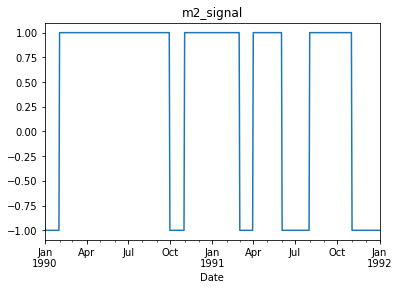

In [6]:
# Dummy Signals used for Testing

# Always Long
AlwaysLong = pd.DataFrame().reindex_like(BondReturnIndex).fillna(1)

# Always Short
AlwaysShort = pd.DataFrame().reindex_like(BondReturnIndex).fillna(-1)

# Gradual Short -> Long
GradualSL = pd.DataFrame().reindex_like(BondReturnIndex).fillna(0)
num_rows, num_cols = GradualSL.shape
for col in GradualSL.columns:
    GradualSL[col] = range(0, num_rows)
GradualSL = 2 * GradualSL / num_rows - 1

# Gradual Long -> Short
GradualLS = -1 * GradualSL

# Sign of M2 Changes
M2Changes = M2.pct_change()
M2Signal = M2Changes / M2Changes.abs()
M2Signal = M2Signal.resample('1B').ffill()

M2Signal['CAN'].plot()
plt.xlabel('Date')
plt.xlim('1990-01','1992-01')
plt.title('m2_signal')
plt.show()

In [218]:
def returns(signal, returnIndex):
    return returnIndex.diff() * signal.shift(1)


def cumulativeReturns(signal, returnIndex):
    return returns(signal, returnIndex).cumsum()


# Input: list of signals and list of corresponding return indexes to trade on
#        (at any point in time, absolute values of signals should add up to at most 1)
# Output: cumulative returns based on this trading strategy
def cumulativeReturnsMultiSignal(signals, returnIndexes):
    assert(max(sum([signal.abs() for signal in signals])) <= 1)
    
    totalCR = returnIndexes[0].copy() * 0
    for i in range(len(signals)):
        totalCR += cumulativeReturns(signals[i], returnIndexes[i])
    return totalCR


def plotCumulativeReturns(signal, returnIndex, title=''):
    Returns = cumulativeReturns(signal, returnIndex)
    Returns.plot()
    returnIndex.diff().cumsum().plot()
    plt.xlim('1980-01','2020-06')
    plt.legend(['Returns Using Signal', 'Return Index'])
    plt.xlabel('Date')
    plt.title(title)
    plt.show()
    
    
def percentReturns(signal, returnIndex, rolling_window):
    return returnIndex.pct_change(rolling_window) * signal.shift(1)


# Might need to fix this one
def plotCumulativePL(signal, returnIndex, title=''):
    Returns = cumulativeReturns(signal, returnIndex)
    (Returns - returnIndex).plot()
    plt.xlim('1980-01','2020-06')
    plt.legend('Cumulative P&L')
    plt.xlabel('Date')
    plt.title(title)
    plt.show()
    
    
def plotReturns(signal, returnIndex, rolling_window, title=''):
    Returns = percentReturns(signal, returnIndex, rolling_window)
    Returns.plot()
    returnIndex.pct_change(rolling_window).plot()
    plt.axhline(y=0, color='grey', linestyle='-')
    plt.xlim('1980-01','2020-06')
    plt.legend(['Returns Using Signal for Country' + country, 'Returns for Country ' + country])
    plt.xlabel('Date')
    plt.title(title)
    plt.show()

date
2020-07-28    327.060539
2020-07-29    325.523991
2020-07-30    328.099044
2020-07-31    326.611887
2020-08-03    326.723845
Freq: B, Name: GBR, dtype: float64


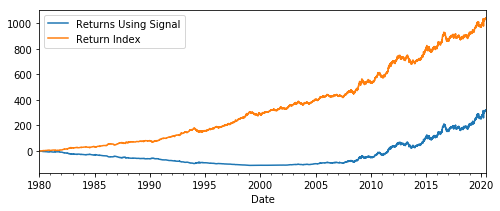

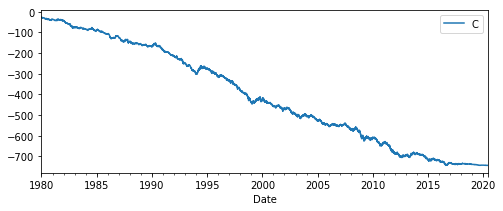

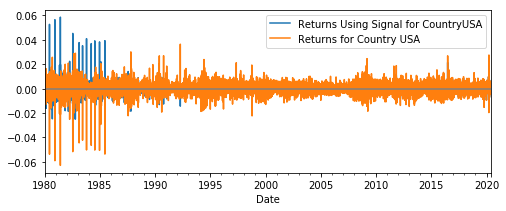

In [219]:
print(cumulativeReturnsMultiSignal([.5 * GradualSL['GBR'], .5 * GradualSL['GBR']], [BondReturnIndex['GBR'], BondReturnIndex['GBR']]).tail())

plotCumulativeReturns(GradualSL['GBR'], BondReturnIndex['GBR'])
plotCumulativePL(GradualSL['GBR'], BondReturnIndex['GBR'])
plotReturns(GradualSL['GBR'], BondReturnIndex['GBR'], 1)

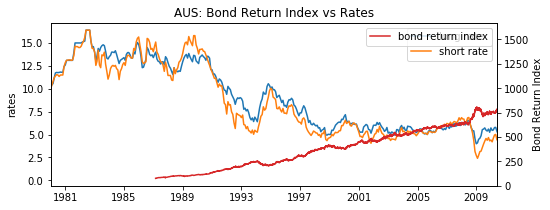

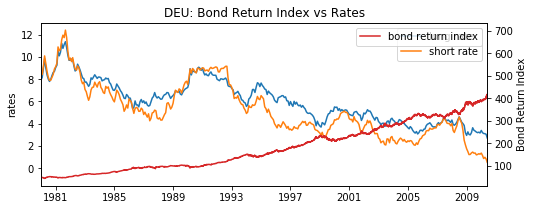

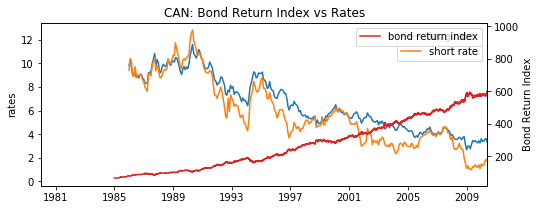

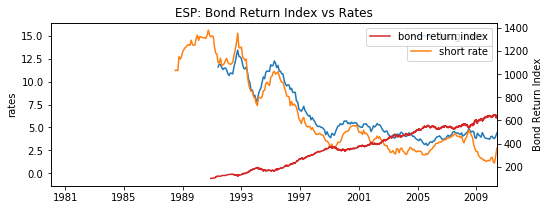

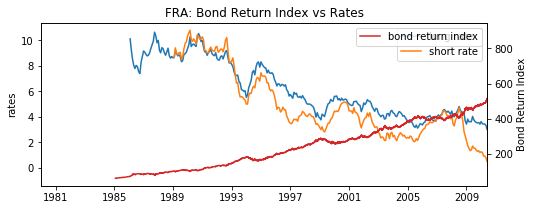

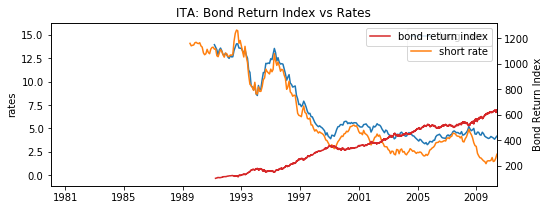

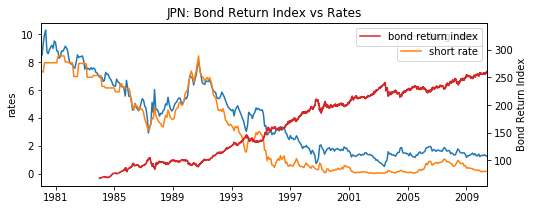

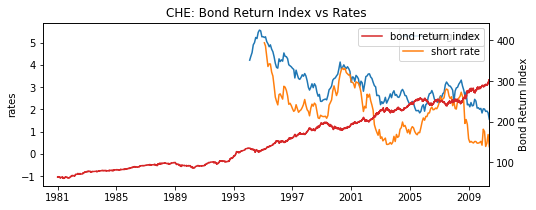

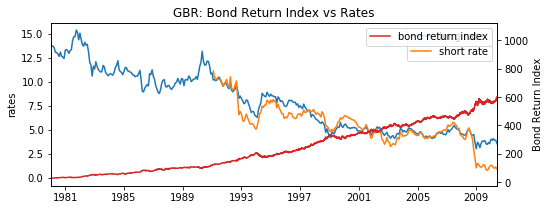

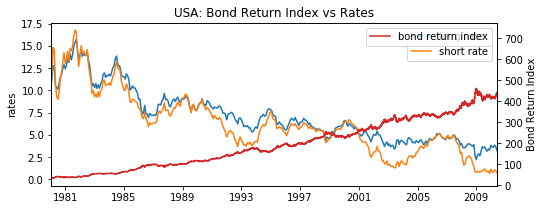

In [196]:
# Visualize bond returns for each country vs long/short rate
for country in BondReturnIndexMonthly.columns:
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(LongRates[country].to_timestamp(), label = 'long rate')
    ax1.plot(ShortRates[country].to_timestamp(), label = 'short rate')
    ax1.set_ylabel("rates")
    ax1.legend()
    ax2.plot(BondReturnIndex[country].to_timestamp(), color = 'tab:red', label = "bond return index")
    ax2.set_ylabel('Bond Return Index')
    ax2.legend()
    plt.title(country + ': Bond Return Index vs Rates')
    plt.xlim('1980-01','2010-06')
    plt.show()

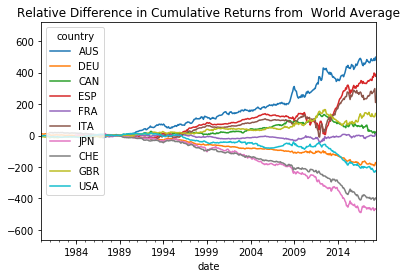

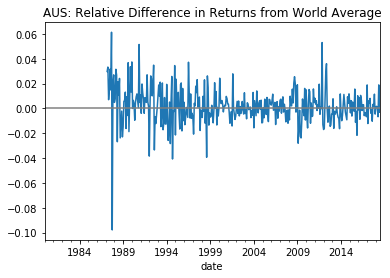

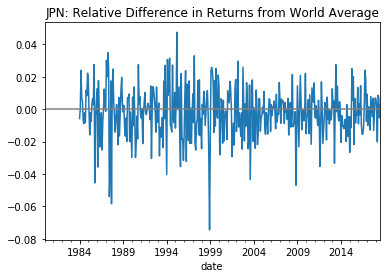

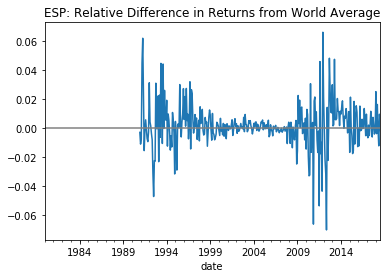

In [10]:
# Deviation in returns from world average

CumBondReturnDifferenceFromWrldAvg = pd.DataFrame().reindex_like(BondReturnIndexMonthly)
for country in countries:
    CumBondReturnDifferenceFromWrldAvg[country] = BondReturnIndexMonthly[country] - BondReturnIndexMonthly.mean(axis=1)

CumBondReturnDifferenceFromWrldAvg.plot()
plt.title('Relative Difference in Cumulative Returns from  World Average')
plt.xlim('1980-01','2018-06')
plt.show()

BondReturnDiffFromWrldAvg['AUS'].plot()
plt.axhline(y=0, color='grey', linestyle='-')
plt.title('AUS: Relative Difference in Returns from World Average')
plt.xlim('1980-01','2018-06')
plt.show()

BondReturnDiffFromWrldAvg['JPN'].plot()
plt.axhline(y=0, color='grey', linestyle='-')
plt.title('JPN: Relative Difference in Returns from World Average')
plt.xlim('1980-01','2018-06')
plt.show()

BondReturnDiffFromWrldAvg['ESP'].plot()
plt.axhline(y=0, color='grey', linestyle='-')
plt.title('ESP: Relative Difference in Returns from World Average')
plt.xlim('1980-01','2018-06')
plt.show()

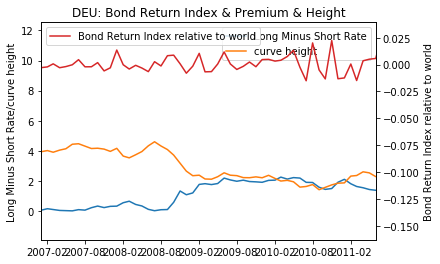

In [11]:
# Research Indicator 1 (Bond Premium = Long-Short Rates & Curve Height)
example_countries = ['DEU']

for country in example_countries:
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1_label = 'Long Minus Short Rate'
    LongMinusShortRateDifference = LongMinusShortRates[country] - LongMinusShortRates.mean(axis=1)
    CurveHeightDifference = CurveHeight[country] - CurveHeight.mean(axis=1)
    ax1.plot(LongMinusShortRates[country].to_timestamp(), label = ax1_label)
    ax1.plot(CurveHeight[country].to_timestamp(), label = 'curve height')
    ax1.set_ylabel(ax1_label + "/curve height")
    ax1.legend()
    ax2_label = 'Bond Return Index relative to world'
    ax2.plot(BondReturnDiffFromWrldAvg[country].to_timestamp(), color = 'tab:red', label = ax2_label)
    ax2.set_ylabel(ax2_label)
    ax2.legend()
    plt.title(country + ': Bond Return Index & Premium & Height')
    plt.xlim('2007-01','2011-06')
    plt.show()

In [12]:
# Time-series cross-correlation from https://stackoverflow.com/questions/33171413/cross-correlation-time-lag-correlation-with-pandas
def crosscorr(datax, datay, lag=0):
    return datax.corr(datay.shift(lag))

# For single country, computes correlation of pct_change in series1 with specific window 
# and returns of series2 with a specific rolling window with future lags up to max_lag
#
# series: indicator data series
# country for comparison
# change_months: how many months for percent change for indicator
# return_months: how many months for computing returns
# max_lag: how many lagging months you want to test correlations for
# output: list of correlations between series for lag = 0 to max_lag
def computeCorrStats(series1, series2, country, change_months, return_months, max_lag):
    x = series2[country].pct_change(return_months)
    y = series1[country].pct_change(change_months)
    return [crosscorr(x, y, lag) for lag in range(return_months, return_months + max_lag)]

def computeCorrWithBondReturns(series, country, change_months, return_months, max_lag):
    return computeCorrStats(series, BondReturnIndexMonthly, country, change_months, return_months, max_lag)

def computeCorrWithBondReturnDiffs(series, country, change_months, return_months, max_lag):
    return computeCorrStats(series, LnBondReturnDiffFromWrldAvg, country, change_months, return_months, max_lag)


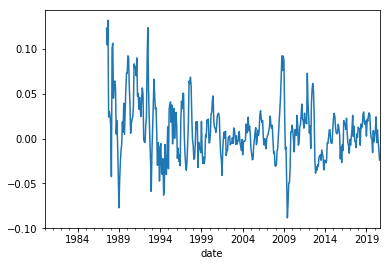

Difference in LongMinusShortRates from global average as predictor?


TypeError: list indices must be integers or slices, not str

In [13]:
# Research on predictive power of LongMinusShortRates

# Compute X-month change in bond return differential between country C and global average
XMonthChanges = {}

for months in range(24):
    BondReturnDiffFromWrldAvg = pd.DataFrame(columns = countries)
    for country in countries:
        BondReturnDiffFromWrldAvg[country] = BondReturnIndexMonthly[country].pct_change(months) - BondReturnIndexMonthly.mean(axis=1).pct_change(months)
    XMonthChanges[months] = BondReturnDiffFromWrldAvg

# Difference in LongMinusShortRates from world average?
LongMinusShortRatesDiffs = pd.DataFrame(columns=countries)

# Want to compute correlation between
# A) difference in bond premium between country C and global average
# & B) X-month change in bond return differential between country C and global average

XMonthChanges[5]['AUS'].plot()
plt.show()

print("Difference in LongMinusShortRates from global average as predictor?")
for country in countries:
    # Compute country difference in bond premium from global average
    LongMinusShortRatesDiffs[country] = LongMinusShortRates[country] - LongMinusShortRates.mean(axis=1)

    # Compute cross-correlations between bond index returns and difference in bond premium from global average
    corrs1 = [crosscorr(XMonthChanges([i][country], LongMinusShortRatesDiffs[country], lag=i)) for i in range(1,25)]
    print(country + ': Max corr of ' + str(max(corrs1)) + ' with ' + str(1 + np.argmax(corrs1)) + '-month change in bond return differential')
    
# THE BELOW CODE IS INCORRECT
# Want to compute correlation between
# A) X-month change in difference in bond premium between country C and global average
# & B) Y-month difference in future returns for country C and global average
    
# Monthly change in Difference in LongMinusShortRates from world average?
# for i in range(1, 13):
#     print("\n" + str(i) + "-month change in Difference in LongMinusShortRates from global average?")
#     for country in example_countries:
#         LongMinusShortRatesDiffsChange = LongMinusShortRatesDiffs.pct_change(i)

#         # Compute cross-correlations between bond index returns and difference in bond premium from global average
#         corrs1 = [crosscorr(BondReturnDiffFromWrldAvg[country], LongMinusShortRatesDiffsChange[country], lag=i) for i in range(24)]
#         print(country + ': Max corr of ' + str(max(corrs1)) + ' with lag of ' + str(np.argmax(corrs1)) + ' months')


In [ ]:
# Normalize Difference in LongMinusShortRates from world average
LongMinusShortRatesDiffsNormalized = (LongMinusShortRatesDiffs - LongMinusShortRatesDiffs.min()) / (LongMinusShortRatesDiffs.max() - LongMinusShortRatesDiffs.min())

# Never finished - Create Indicator for DEU out of 5-Month Changes in LongMinusShortRatesDiff
linear_regressor = LinearRegression()
linear_regressor.fit(LongMinusShortRatesDiffsChange['DEU'], )

Correlations for 6-month fxVsUSD change and 1-month returns with 0, 1, ...  5-month lag
[-0.011731395695858769, -0.014834182644451285, 0.0009343634062876896, -0.001371652431629279, 0.003034123088419384, 0.0010304528511821199]
Correlations for 6-month fxVsUSD change and 2-month returns with 0, 1, ...  5-month lag
[-0.017591463143028944, -0.009123620331947073, 9.29074108687076e-05, 0.0015753156550374246, 0.003756202236764585, 0.011135262204814304]
Correlations for 6-month fxVsUSD change and 3-month returns with 0, 1, ...  5-month lag
[-0.013217060959256666, -0.00786720252581843, 0.001045804470118819, 0.0010146700287122202, 0.010508591062454158, 0.01679965443449798]
Correlations for 6-month fxVsUSD change and 4-month returns with 0, 1, ...  5-month lag
[-0.01249252369274971, -0.006715910829938202, 3.281583234144111e-05, 0.0071418871755910334, 0.015636816437759472, 0.007639289032460418]
Correlations for 6-month fxVsUSD change and 5-month returns with 0, 1, ...  5-month lag
[-0.010921224744

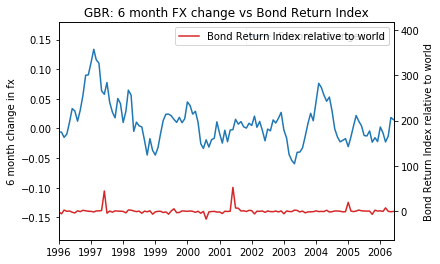

In [14]:
# Let's work on currency appreciation over last 6 months as predictor of country's positive bond performance
fxVsUSD = dl.pull("fxVsUSD")
fxTrdWts = dl.pull("fxTrdWts/Nominal")

# And let's just work with GBR
example_countries = ['GBR']

for return_window in range(1,12):
    print("Correlations for 6-month fxVsUSD change and " + str(return_window) + "-month returns with 0, 1, ...  5-month lag")
    print(computeCorrWithBondReturns(fxVsUSD, 'GBR', 6, return_window, 6))
print("\n----------------------------------------\n")
    
for return_window in range(1,12):
    print("Correlations for 6-month fxTrdWts change and " + str(return_window) + "-month returns with 0, 1, ...  5-month lag")
    print(computeCorrWithBondReturns(fxTrdWts, 'GBR', 6, return_window, 6))
print("\n----------------------------------------\n")
    
for return_window in range(1,12):
    print("Correlations for 6-month fxTrdWts change and " + str(return_window) + "-month return diffs with 0, 1, ...  5-month lag")
    print(computeCorrWithBondReturnDiffs(fxVsUSD, 'GBR', 6, return_window, 6))
print("\n----------------------------------------\n")
    
for return_window in range(1,12):
    print("Correlations for 6-month fxTrdWts change and " + str(return_window) + "-month return diffs with 0, 1, ...  5-month lag")
    print(computeCorrWithBondReturnDiffs(fxTrdWts, 'GBR', 6, return_window, 6))
print("\n----------------------------------------\n")

# Compute 6-month change in fx vs Bond Return Index
for country in example_countries:
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1_label = '6 month change in FX'
    ax1.plot(fxTrdWts[country].pct_change(6).to_timestamp(), label = '5 month change in fx')
    ax1.set_ylabel('6 month change in fx')
    ax1.legend()
    ax2_label = 'Bond Return Index relative to world'
    ax2.plot(LnBondReturnDiffFromWrldAvg[country].pct_change(3).to_timestamp(), color = 'tab:red', label = ax2_label)
    ax2.set_ylabel(ax2_label)
    ax2.legend()
    plt.title(country + ': 6 month FX change vs Bond Return Index')
    plt.xlim('1996-01','2006-06')
    plt.show()

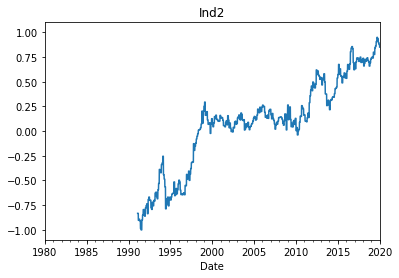

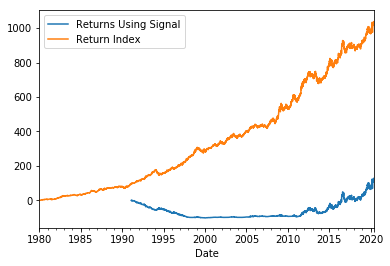

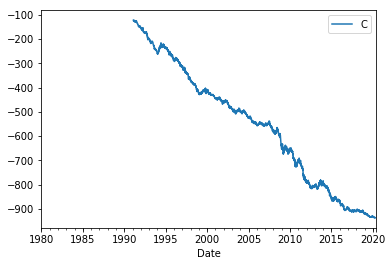

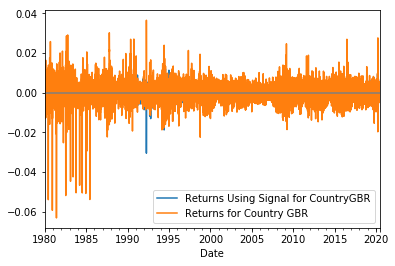

In [19]:
# Create Indicator out of Long - Short & Curve Height (First Pass -- dumb normalization)
Ind1 = LongMinusShortRates.mean() - LongMinusShortRates + CurveHeight.mean() - CurveHeight
# Ind2 = SixMonthFxChange

# Resample to business days
Ind1 = Ind1.resample('1B').ffill()
# Ind2 = SixMonthFxChange.resample('1B').ffill()

# Normalize (min-max) Ind 1
Ind1 = 2 * ((Ind1 - Ind1.min()) / (Ind1.max() - Ind1.min())) - 1
# Ind2 = 2 * ((Ind2 - Ind2.min()) / (Ind2.max() - Ind2.min())) - 1

# Plot
Ind1['GBR'].plot()
plt.xlabel('Date')
plt.xlim('1980-01','2020-01')
plt.title('Ind2')
plt.show()

# Show Returns for Ind1
plotCumulativeReturns(Ind1['GBR'], BondReturnIndex['GBR'])
plotCumulativePL(Ind1['GBR'], BondReturnIndex['GBR'])
plotReturns(Ind1['GBR'], BondReturnIndex['GBR'], 1)

In [253]:
# Shift Gears for Different Focus

# Research on Betting on Global Bonds vs Relative Country Positions (Aug 10-11)

In [254]:
# Trading on global bond return
GlobalBondReturnsMonthly = BondReturnIndexMonthly.mean(axis=1)

# Creates signal of perfect trades if you know the return `periods` periods into the future with certainty
def perfectTrades(periods, returnIndex):
    
    # BUG: NEED TO ACCOUNT FOR THE FACT THAT NUMBERS ARE NEGATIVE SO PERCENT CHANGE DOWN IS POSITIVE!!!!!
    
    returnIndex.plot()
    plt.show()
    PerfectTrades = returnIndex.pct_change(periods)
    PerfectTrades /= PerfectTrades.abs()
    PerfectTrades.plot()
    plt.show()
    PerfectTrades = PerfectTrades.shift(-periods)
    print(PerfectTrades.value_counts())
    return PerfectTrades

# Creates signal of biased approximately perfect trades if you know the return `periods` periods into the future 
# with probability p if market goes up and probability q if market goes down
def biasedApproxPerfectTrades(periods, returnIndex, p, q):
    PerfectTrades = perfectTrades(periods, returnIndex)
    for date in PerfectTrades.index:
        if PerfectTrades[date] == 1 and random.random() > p:
            PerfectTrades[date] = -1
        elif PerfectTrades[date] == -1 and random.random() > q:
            PerfectTrades[date] = 1
    return PerfectTrades

# Creates signal of approximately perfect trades if you know the return 
# `periods` periods into the future with probability p
def approxPerfectTrades(periods, returnIndex, p):
    return biasedApproxPerfectTrades(periods, returnIndex, p, p)

# Input: monthList: list of different amounts of months out for return knowledge, ie: [12, 24]
#        returnIndex: return index to trade
#        p: probability you know return in the future if market goes up in reality
#        q: probability you know return in the future if market goes down in reality
# Output: dictionary with cumulative returns for each month in monthList
#         {12: cumulative returns for trading on 12 months out with p and q, 
#          24: cumulative returns for trading on 24 months out with p and q}
def cumBiasedApproxPerfectReturns(monthList, returnIndex, p, q):
    CumBiasedApproxPerfectReturns = {}
    for months in monthList:
        BiasedApproxPerfectTrades = biasedApproxPerfectTrades(months, returnIndex, p, q)
        CumBiasedApproxPerfectReturns[months] = cumulativeReturns(BiasedApproxPerfectTrades, returnIndex)
    return CumBiasedApproxPerfectReturns

# Input: monthList: list of different amounts of months out for return knowledge, ie: [12, 24]
#        returnIndex: return index to trade
#        p: probability that knowledge about future is correct
# Output: graph of cumulative returns for each perfect trading scenario
def plotCumBiasedApproxPerfectReturns(monthList, returnIndex, p, q, title, returnIndexName='Global Bond Market', ymin=0, ymax=2000):
    legend = []
    CumBiasedApproxPerfectReturns = cumBiasedApproxPerfectReturns(monthList, returnIndex, p, q)
    for months in CumBiasedApproxPerfectReturns:
        CumBiasedApproxPerfectReturns[months].plot()
        legend.append('Returns knowing ' + str(months) + ' months out')
        
    # Plot cumulative returns from index with no betting
    returnIndex.diff().cumsum().plot()
    legend.append('Return Index for ' + returnIndexName)
    
    plt.legend(legend)
    plt.xlim('1980-01','2020-06')
    plt.ylim(ymin,ymax)
    plt.xlabel('Date')
    plt.title(title)
    plt.show()
    
def cumApproxPerfectReturns(monthList, returnIndex, p):
    return cumBiasedApproxPerfectReturns(monthList, returnIndex, p, p)

def cumPerfectReturns(monthList, returnIndex):
    return cumBiasedApproxPerfectReturns(monthList, returnIndex, 1, 1)
    
def plotCumApproxPerfectReturns(monthList, returnIndex, p, title, returnIndexName='Global Bond Market', ymin=0, ymax=2000):
    return plotCumBiasedApproxPerfectReturns(monthList, returnIndex, p, p, title, returnIndexName, ymin, ymax)
    
def plotCumPerfectReturns(monthList, returnIndex, title, returnIndexName='Global Bond Market', ymin=0, ymax=2000):
    return plotCumBiasedApproxPerfectReturns(monthList, returnIndex, 1, 1, title, returnIndexName, ymin, ymax)

# List of months out for futue visualizations
MonthList = [1, 3, 6, 12, 24, 48]


In [255]:
# Smaller visualizations (going to have a lot coming up!)
plt.rcParams['figure.figsize'] = [8, 3]

### What do returns look like if you had perfect information about an individual country's bond return index X time into the future? (Australia - best & Japan - worst)

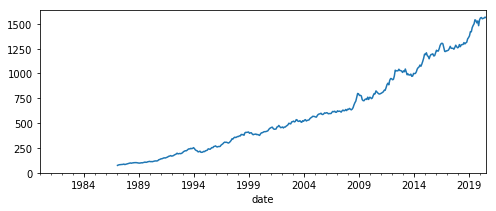

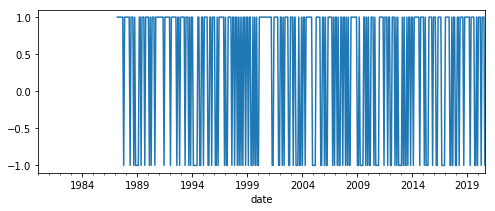

 1.0    261
-1.0    141
Name: AUS, dtype: int64


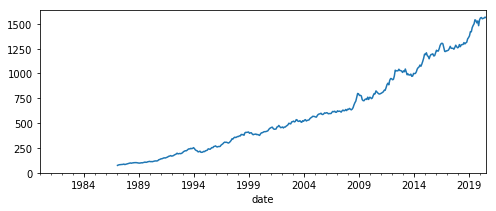

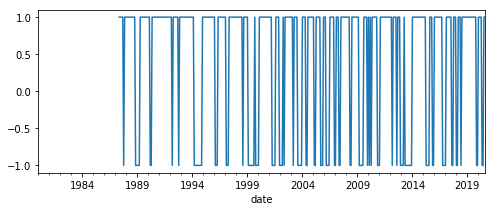

 1.0    287
-1.0    113
Name: AUS, dtype: int64


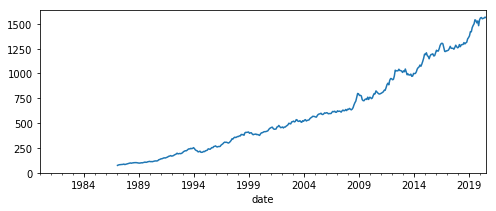

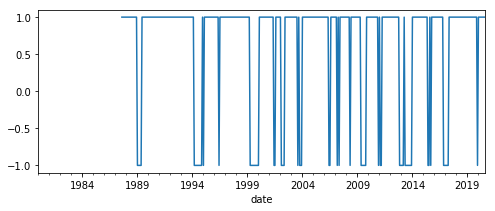

 1.0    324
-1.0     73
Name: AUS, dtype: int64


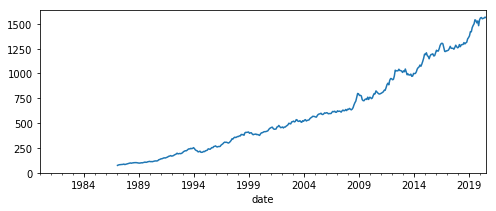

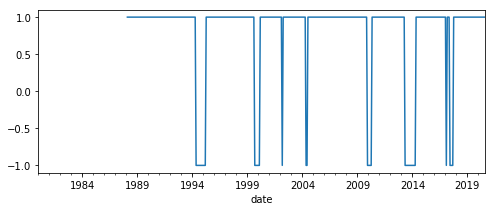

 1.0    349
-1.0     42
Name: AUS, dtype: int64


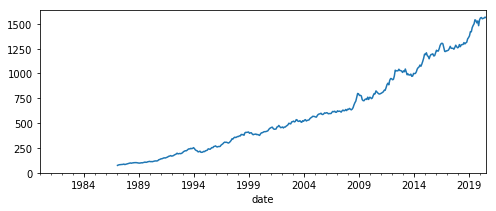

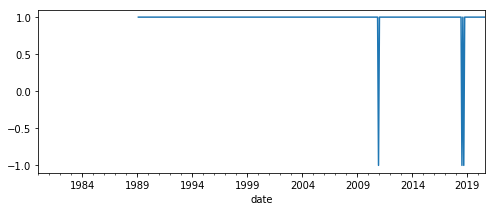

 1.0    376
-1.0      3
Name: AUS, dtype: int64


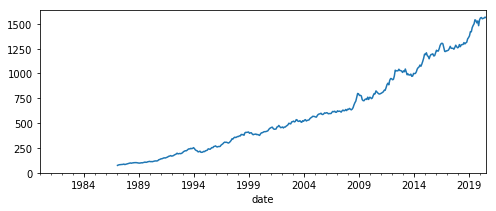

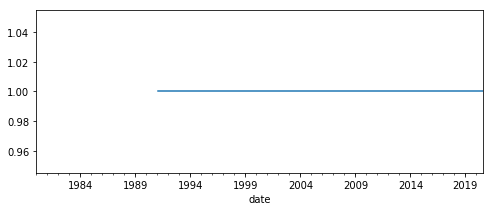

1.0    355
Name: AUS, dtype: int64


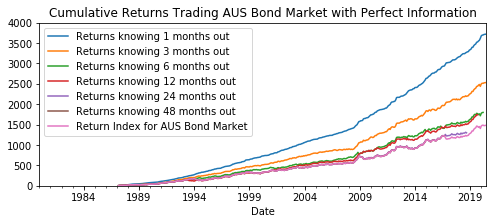

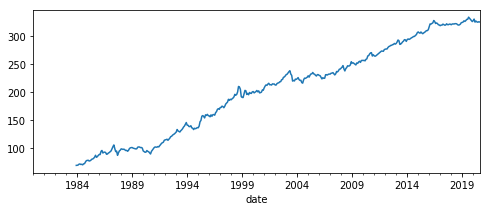

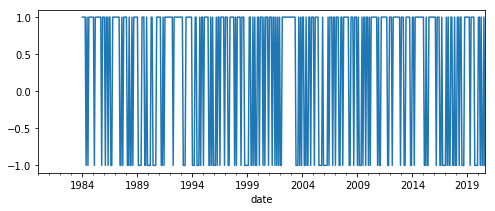

 1.0    281
-1.0    159
Name: JPN, dtype: int64


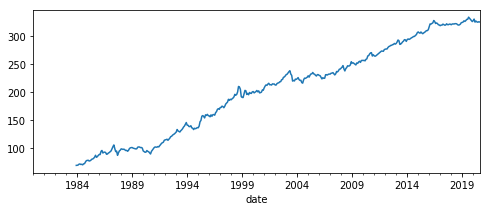

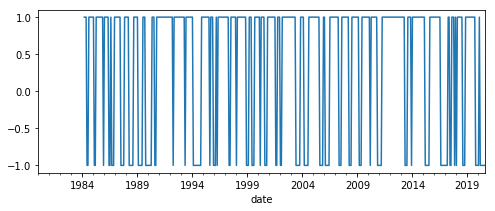

 1.0    304
-1.0    134
Name: JPN, dtype: int64


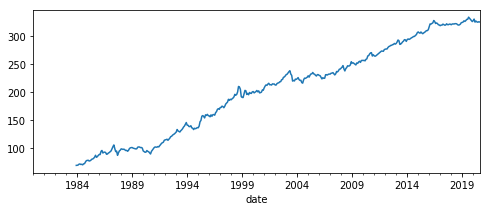

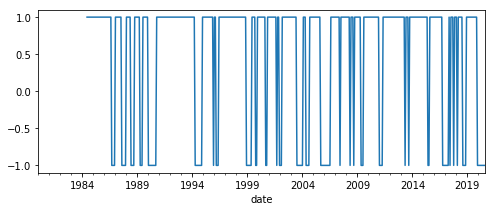

 1.0    325
-1.0    110
Name: JPN, dtype: int64


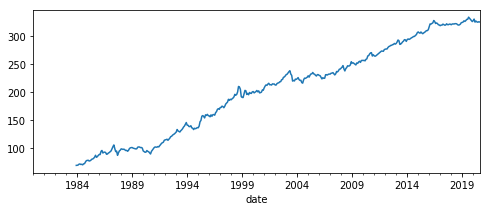

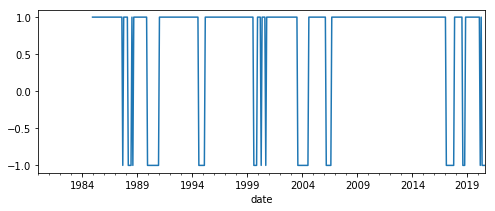

 1.0    362
-1.0     67
Name: JPN, dtype: int64


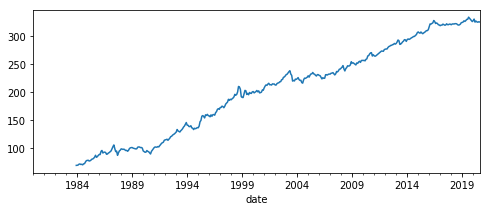

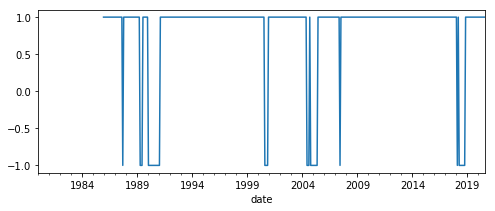

 1.0    376
-1.0     41
Name: JPN, dtype: int64


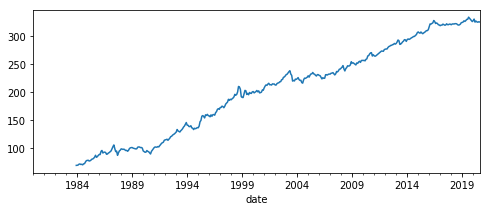

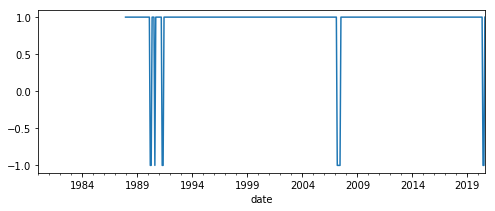

 1.0    382
-1.0     11
Name: JPN, dtype: int64


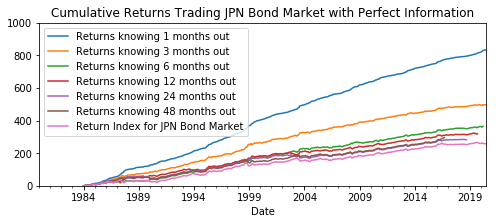

In [256]:
plotCumPerfectReturns(MonthList, BondReturnIndexMonthly['AUS'], 
                      'Cumulative Returns Trading AUS Bond Market with Perfect Information', 
                      'AUS Bond Market', 
                      0, 4000)
plotCumPerfectReturns(MonthList, BondReturnIndexMonthly['JPN'], 
                      'Cumulative Returns Trading JPN Bond Market with Perfect Information', 
                      'JPN Bond Market', 
                      0, 1000)

 ### What do returns look like if you had perfect information about the global bond return index X months into the future?

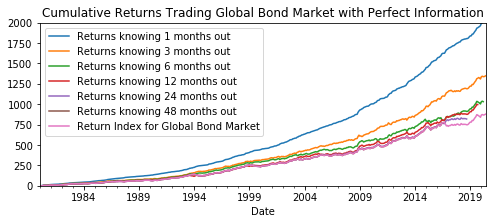

Average Annual Return for 1 months out: 1.1033946965439592
Average Annual Return for 3 months out: 1.0927948922507744
Average Annual Return for 6 months out: 1.086087268300388
Average Annual Return for 12 months out: 1.0862448175392345
Average Annual Return for 24 months out: 1.0830843591057062
Average Annual Return for 48 months out: 1.0862335257165965


In [136]:
plotCumPerfectReturns(MonthList, GlobalBondReturnsMonthly, 'Cumulative Returns Trading Global Bond Market with Perfect Information')

# TODO: turn this ARR computation into function above
# Compute effective annualized return rates for each strategy
CumPerfectReturns = cumulativePerfectReturns(MonthList, GlobalBondReturnsMonthly)
InitialCapital = GlobalBondReturnsMonthly[0]
InitialDate = GlobalBondReturnsMonthly.first_valid_index()
for months in CumPerfectReturns:
    cprm = CumPerfectReturns[months]
    FinalDate = cprm.last_valid_index()
    FinalCumReturns = cprm[FinalDate]
    TotalMonths = (FinalDate - InitialDate).n
    AAR = (FinalCumReturns/InitialCapital) ** (12 / TotalMonths)
    print("Average Annual Return for " + str(months) + " months out: " + str(AAR))
    

### What do returns look like if you had <i>approximately</i> perfect information (equal error for when market moves up or down) about the global bond return index X months into the future?

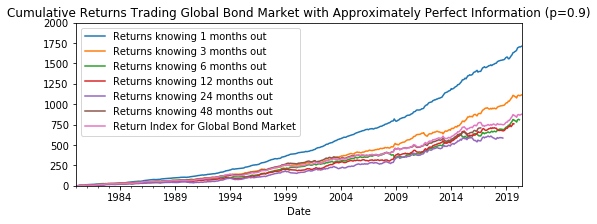

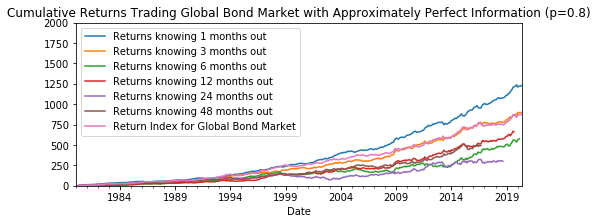

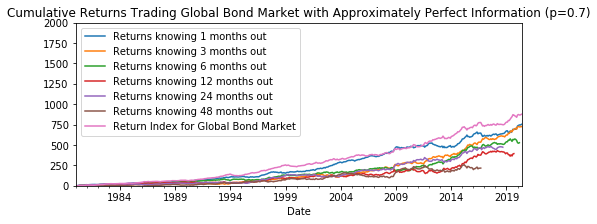

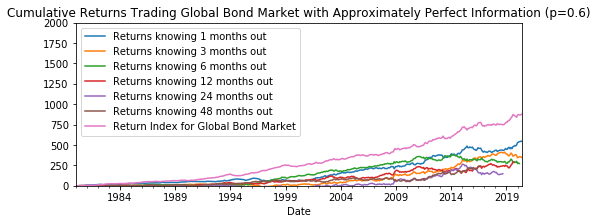

In [143]:
probs = [.9, .8, .7, .6]

for p in probs:
    plotCumApproxPerfectReturns(MonthList, GlobalBondReturnsMonthly, p, 
                            'Cumulative Returns Trading Global Bond Market with Approximately Perfect Information (p=' + str(p) + ')')

# TODO: these line charts currently involve randomness, so make some that include expected error bars like these:
# https://stackoverflow.com/questions/43701489/how-to-plot-a-line-chart-with-error-values-in-matplotlib
# https://www.absentdata.com/python-graphs/seaborn-line-chart/

### What do returns look like if you had <i>biased approximately</i> perfect information (prob p of being correct for when market moves up/prob q of being correct when market moves down) about the global bond return index X months into the future?

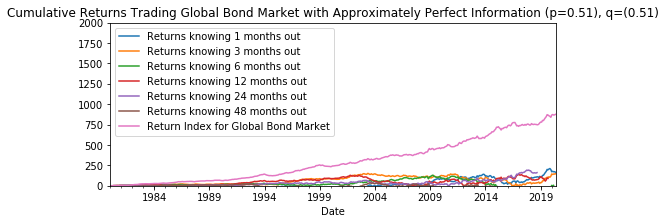

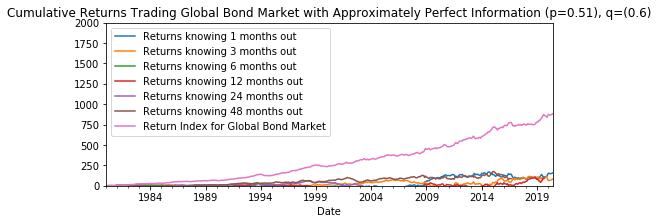

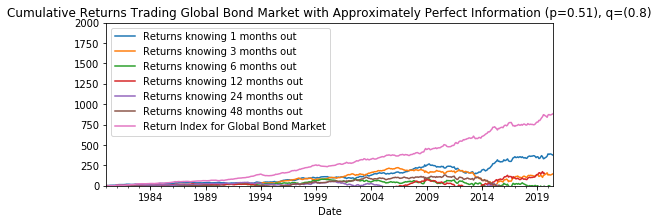

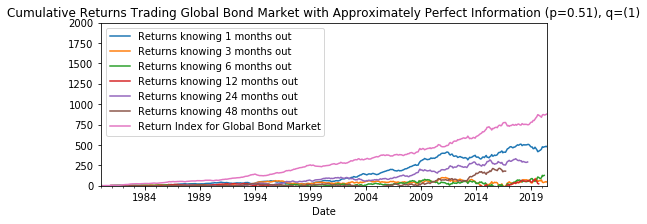

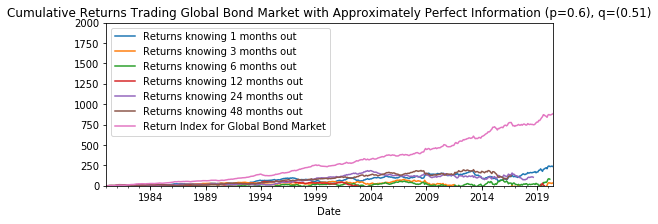

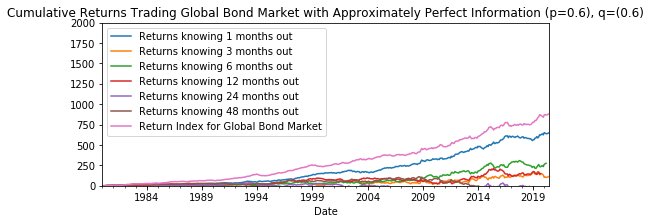

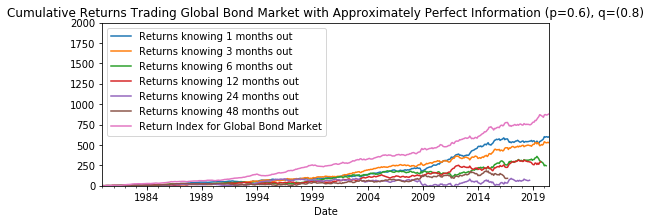

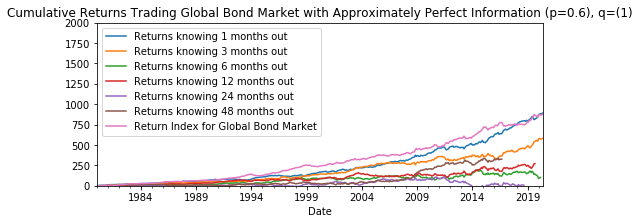

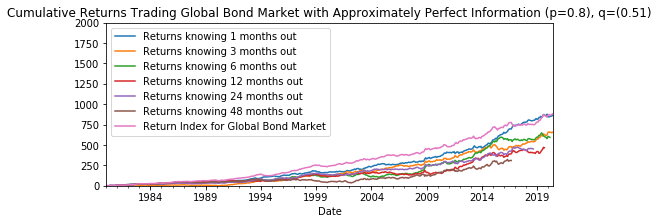

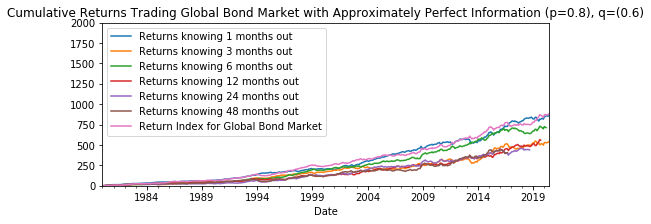

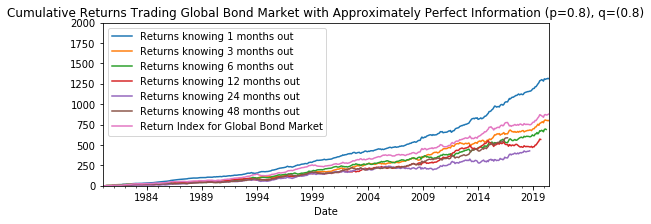

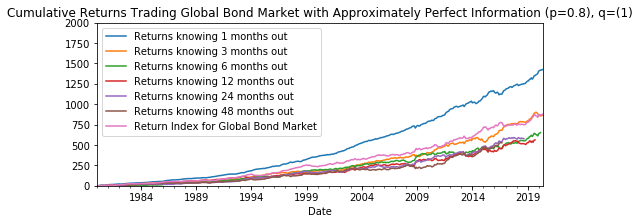

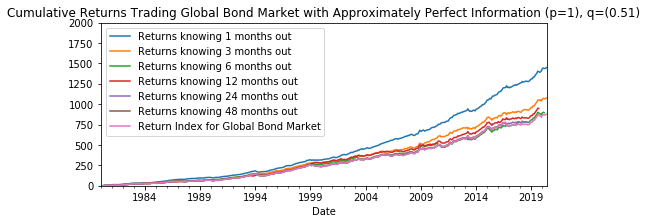

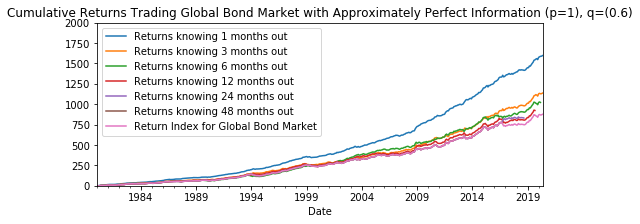

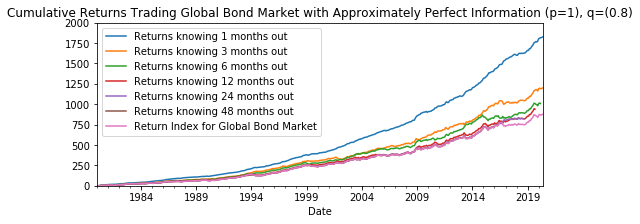

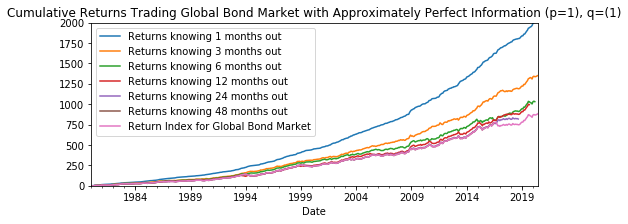

In [138]:
probs = [.51, .6, .8, 1]

for p in probs:
    for q in probs:
        plotCumBiasedApproxPerfectReturns(MonthList, GlobalBondReturnsMonthly, p, q, 
                                          'Cumulative Returns Trading Global Bond Market with Approximately Perfect Information (p=' + str(p) + '), q=(' + str(q) + ')')


In [ ]:
# TODO
# Currently p = 0.8 means prob(you correctly bet long | market goes up)
# We should also consider a different version of the prob values....
# p = 0.8 means prob(market goes up | you bet market goes up)

### What do returns look like if you had perfect information about the change in a country's relative position X time into the future? (Using Bond Prospectus Strategy)

In [ ]:
# Input: periods: You know perfect trade `period` periods into the future with certainty
#        country: country for making perfect trades
# Output: [signal for trading country's bond market, signal for trading global bond market]
def perfectTradesRelativeOneCountry(periods, country):
    PerfectTradesOnDifference = perfectTrades(periods, CumBondReturnDifferenceFromWrldAvg[country])
    return [.5 * PerfectTradesOnDifference, -.5 * PerfectTradesOnDifference]

# def plotCumBiasedApproxPerfectReturnsRelative(monthList, country, p, q, title, returnIndexName='Global Bond Market', ymin=0, ymax=2000):
#     legend = []
#     CumBiasedApproxPerfectReturnsRelative = cumBiasedApproxPerfectReturns(monthList, CumBondReturnDifferenceFromWrldAvg[country], p, q)
#     for months in CumBiasedApproxPerfectReturns:
#         CumBiasedApproxPerfectReturns[months].plot()
#         legend.append('Returns knowing ' + str(months) + ' months out')
        
#     # Plot cumulative returns for Global Bond Market (original benchmark)
#     GlobalBondReturnsMonthly.diff().cumsum().plot()
#     legend.append('Return Index for Global Bond Market')
    
#     plt.legend(legend)
#     plt.xlim('1980-01','2020-06')
#     plt.ylim(0,ylim)
#     plt.xlabel('Date')
#     plt.title(title)
#     plt.show()
    
# def plotCumPerfectReturnsRelative(monthList, country, title, returnIndexName='Global Bond Market', ylim=2000):
#     return plotCumBiasedApproxPerfectReturns(monthList, country, 1, 1, title, returnIndexName, ylim)

cumulativeReturnsMultiSignal
perfectTradesRelativeOneCountry(2, 'ESP')


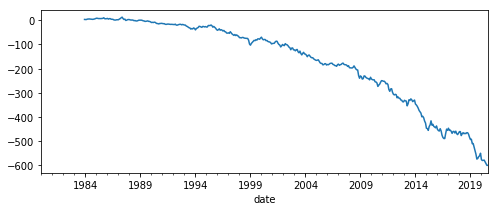

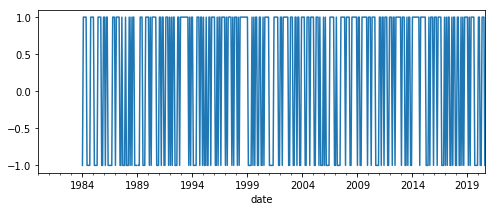

 1.0    265
-1.0    174
Name: JPN, dtype: int64


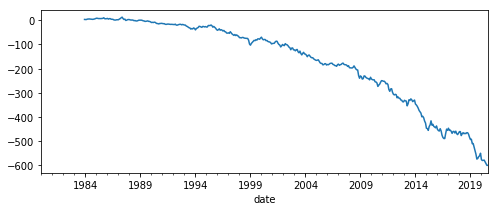

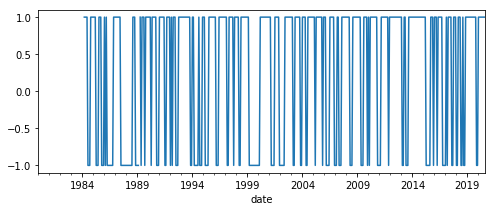

 1.0    288
-1.0    149
Name: JPN, dtype: int64


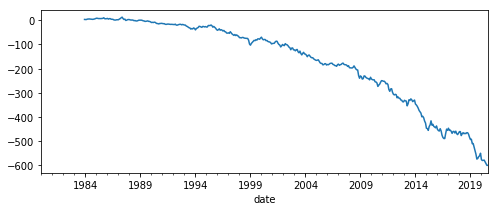

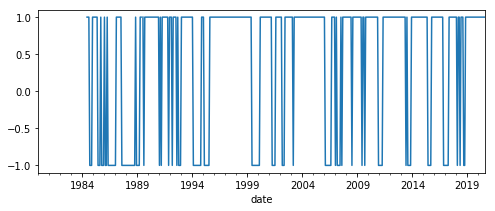

 1.0    314
-1.0    120
Name: JPN, dtype: int64


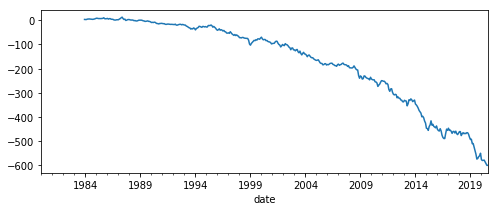

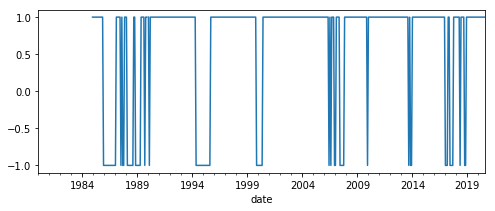

 1.0    350
-1.0     78
Name: JPN, dtype: int64


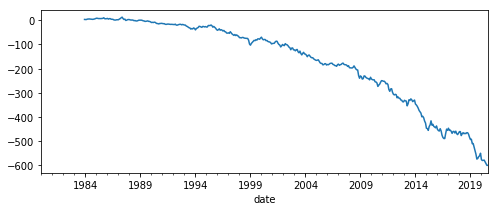

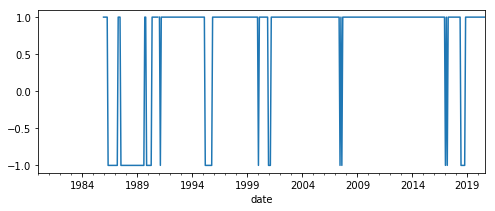

 1.0    351
-1.0     65
Name: JPN, dtype: int64


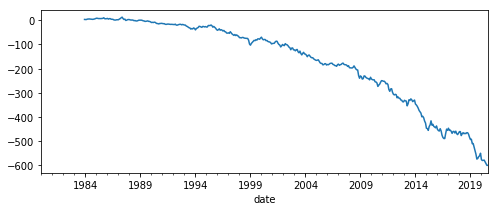

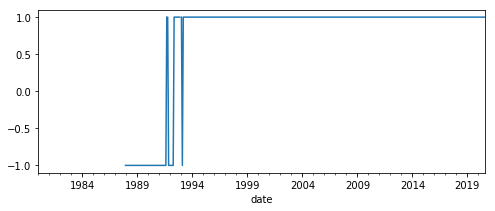

 1.0    340
-1.0     52
Name: JPN, dtype: int64


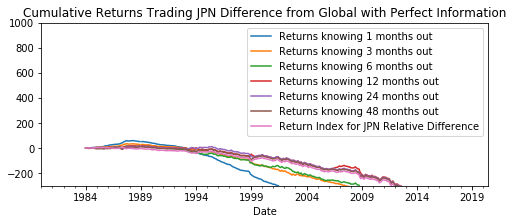

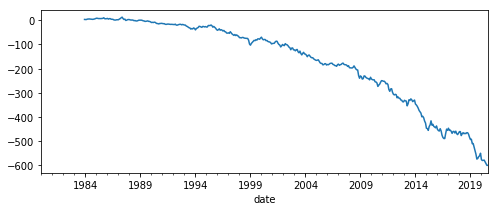

In [257]:
# TODO: Work on same analysis with perfect relative pos. from bond prospectus for trading 1 country

# plotCumPerfectReturns(MonthList, CumBondReturnDifferenceFromWrldAvg['ESP'], 
#                       'Cumulative Returns Trading ESP Difference from Global with Perfect Information', 
#                       'ESP Relative Difference')
# plotCumPerfectReturns(MonthList, CumBondReturnDifferenceFromWrldAvg['AUS'], 
#                       'Cumulative Returns Trading AUS Difference from Global with Perfect Information', 
#                       'AUS Relative Difference',
#                      0, 2500)
plotCumPerfectReturns(MonthList, CumBondReturnDifferenceFromWrldAvg['JPN'], 
                      'Cumulative Returns Trading JPN Difference from Global with Perfect Information', 
                      'JPN Relative Difference',
                     -300, 1000)

CumBondReturnDifferenceFromWrldAvg['JPN'].plot()
plt.show()

In [ ]:
# TODO: Work on same analysis with approx perfect relative pos. from bond prospectus for trading 1 country

In [ ]:
# TODO: same analysis with trading the relative position of 2 countries, 3 countries, ...

### What do returns look like if you had perfect information about the change in a country's long rates X time into the future and used that to bet on global bond return index?
#### (assuming that long rates and bond return index are inversely correlated)